# Martin Iniguez de Onzono Muruaga. Summer Semester 2022.

# Sulphur mollies' waves model

## Introduction

*Poecilia sulphuraria*, also known as sulphur mollies, are a variety of fish, highly endemic to some sulphide spring complexes in Mexico, being discovered in *Baños del Azufre*, which literally translates to "Sulphur Baths" in Spanish. 
These small extremophiles which can grow up to 12 cm, are used to these $H_{2}S$-rich waters, in which they can be found in high abundance and density **[1]**.

Due to water's low oxygen content, mollies gather at the surface to be able to breath air. For avian predators, that is a perfect scenario, in which they can spot their preys easily and pull them out of the water without having to dive inside the sulphide springs. These mollies have developed a remarkable collective antipredator behavior, based on high density of its kind and "trust" in their school of fish and their neighbors.
    
Once a molly detects an anomaly in its surroundings (very well may be spotting a bird or another animal going around them, or just a leaf falling on top of the water), they will dive into safety. Surrounding mollies will follow, forming "fish waves" that can be very visible from the surface, and expand acroos the pond. Sometimes this dives are just random, or are not due to a specific threat, and mollies will also follow their partners. These waves also produces some visual effect on the predators, which are discouraged to go into the water since a bigger predator producing these waves could be hiding in them **[2]**.

## Mathematical Model

Those waves create a challenge for the creation of a model representating those waves in a large population of mollies. For that a 100x100 square matrix was created, in which each cell represented the state of a fish: 0 for being in the surface (**S**), 1 for staying at the bottom (**B**), and 2 for diving in (**D**). The matrix started as all the values set to 0 (no disturbance yet occured), and these states were updated every time step (0.1 s), until a simulation of 30 s was completed (total 300 time steps simulated).

In an early stage of the model, the inclusion of only 2 possible states (surface and underwater) was contemplated. However, the inclusion of a 3$^{rd}$ one reduced the complexity of the system (no need to record how long has passed since a change of state has occured), it introduces an absolute refractory period (at least 1 time step), and it allows for easier visualization: the splash produced by the waves can be visualized thanks to a color map showing the fish exactly when they dive in.
  
Once it was established that the fishes could be in three different states, a stochastic model was set to produce the changes from one state to the next one, encompassing these three important factors:

-  Time they can stay underwater without breathing pure air (represented mathematically by parameter $\alpha$ ).
-  How frequent random dives happen ($\beta$ ).
-  Trust of the fish to their peers ($\gamma$).

Thus, the transition probability from Surface state to Diving one depends on parameters $\beta$ and $\gamma$, the transition probability from Bottom to Surface depends on $\alpha$, and Diving follows into Bottom state directly after 1 time step (time that it takes for the fish to dive in).

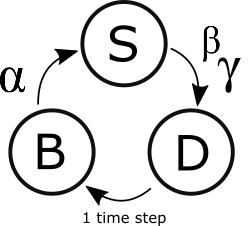

In [1]:
from IPython.display import Image

Image('diagram.png')

To calculate those transition probabilities I used the following equations:

$$ P_i(S_{t+1}|B_{t}) = \alpha $$

$$ P_i(D_{t+1}|S_{t}) = \sum_{neighbors} \gamma d_{j,t} + \beta $$

$$ P_i(B_{t+1}|D_{t}) = 1 $$

In the first equation, the transition probability of a fish to go from resurface in the next time step is $\alpha$, which would represent the time a fish can stay underwater until the urge of going up to the surface is too strong. 

In the second equation, the transition probability of a fish to dive in, is the sum of the state of the surrounding neighbors, being $d_{i,t}$ = 1 when a neighboring fish *i* is diving in time step *t*, and 0 otherwise. This sum is weighted by parameter $\gamma$, reflecting the trust of the fish to its peers. If $\gamma$ is equal to 1, it means that whenever there is 1 fish diving in, all of its neighbors will follow, for 0.5, it would mean half of its neighbots follow, and so on. As the system starts with all fishes at the surface, it needs a stochastic parameter $\beta$ that allows for random diving of the fish, or the system would remain static at the fixed point corresponding to all the points of the grid being 0.

As for the last equation, it is pretty easy. The Diving state is an unstable one in which the fish only remain for 1 time step.

## Computational Model

First, all the necessary tools and packages are imported.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib
from matplotlib.colors import ListedColormap

Now, the functions that are used to embellish or shorten the computation in the final code are presented here.

In [3]:
# Function that detects whether the index provided of the cell lies on an edge of the grid. 
def edges(grid_dim, index):
    if index == 0: # If we are on the first row/column
        start_index = 0;
        end_index = index + 2;
    elif index == grid_dim - 1: # If we are on the last row/column
        start_index = index-1;
        end_index = grid_dim;
    else:
        start_index = index- 1;
        end_index = index + 2;
    return start_index, end_index    

# Function that provides the 3x3 grid surrounding a cell with the state of all the neighbors (smaller when in the edges).
def surroundings(grid, row_ind, column_ind):
    height, width = grid.shape
    start_row, end_row = edges(height, row_ind)
    start_col, end_col = edges(width, column_ind)
    
    neighbors = grid[start_row:end_row, start_col:end_col]
    return neighbors

# Function that gives the appropiate color map and functions for the color bar so we have the desired colors in the graph.
def give_color_map():
    
    col_dict={0:"#0066cc",
          1:"#808080",
          2:"white"}

    cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

    labels = np.array(["Surface","Bottom","Dive in"])
    len_lab = len(labels)

    norm_bins = np.sort([*col_dict.keys()]) + 0.5
    norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)

    norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
    fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

    return cm, norm, norm_bins, fmt

Then, the functions that calculate whether there is a stochastic change of state or not.

In [4]:
# In the case of being at the Bottom, it will rise up if alpha > random number generated between 0 and 1.
def come_up(prob_go_up):
    p = prob_go_up
    rand_num = np.random.random()
    state = p < rand_num
    return int(state)

# In the case of being at the Surface, it will dive if the weighted sum of the amount of diving neighbors + beta
# is greater than a random number between 0 and 1.
def dive_in(grid, row_ind, col_ind, weight_neigh, stoch_param):
    neighbors = surroundings(grid, row_ind, col_ind)
    prob = sum(sum((neighbors==2))) * weight_neigh + stoch_param
    rand_num = np.random.random()
    diving = prob > rand_num
    if diving:
        return 2
    else:
        return 0

Here, I define the main parameters of the model, being the time step (0.1 s), the length of the simulation, the grid size, and which will be the gammas, alphas, and betas I will use to look at different scenarios.

In [5]:
dt = 0.1 #s
total_time = 30 #s
time_steps = np.arange(0,total_time,dt)

grid_size = 100

gamma = [0.15, 0.4, 0.9] # 0.4 default, Weight of the neighboring dives
beta = [0.02, 2e-5, 2e-7] # 2e-05 default, Stochastic going down
alpha = [0.3, 5e-2, 5e-4] # 5e-2 default, Prob coming up

# Parameters used in visualization of the color maps.
cm, norm, norm_bins, fmt = give_color_map()
diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2

Finally, the main code, in which different loops are used to look at different combinations of the parameters so the one that better approximates to the real scenario is found. Videos are created as animation so the whole dynamics can be appreciated.

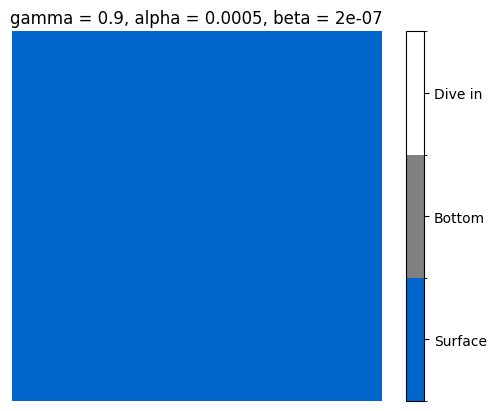

In [6]:
for weight_neigh in gamma:
    for stoch_param in beta:
        for prob_come_up in alpha:
            
            grid = np.zeros((grid_size, grid_size))
            fig,ax = plt.subplots()
            frames = [] # for storing the generated images
            
            for t in time_steps:
                new_grid = grid.copy() # important to create a copy of the grid every time
                
                for i in range(0, grid_size):
                    for j in range(0, grid_size):
                        
                        state = grid[i,j]
                        if state == 0:
                            state = dive_in(grid, i, j, weight_neigh, stoch_param)
                        elif state == 1:
                            state = come_up(prob_come_up)
                        elif state == 2:
                            state = 1
                        new_grid[i,j] = state

                grid = new_grid.copy()
                img = ax.imshow(grid, cmap=cm, norm=norm)
                ax.axis("off")

                # Color bar settings
                if t == 0:
                    cb = fig.colorbar(img, format=fmt, ticks=tickz)

                ax.set_title("gamma = " + str(round(weight_neigh,1)) + ", alpha = "+ str(prob_come_up) + ", beta = " + str(stoch_param))
                plt.show()
                frames.append([img]) # Append the image as a frame to the video
                
            name = str(weight_neigh)+"_"+str(prob_come_up)+"_"+str(stoch_param)
            fig.savefig(r"C:\\temp5\\photo" + name+'.png')
            
            ani = matplotlib.animation.ArtistAnimation(fig, frames, interval=dt*1000, blit=True,
                                            repeat_delay=1000)
      
            ani.save(r"C:\\temp5\\" + name + ".gif", writer='imagemagick')

## Results & Discussion

After performing simulations changing the three key parameters, we were able to find one that ended up being the most accurate representation of the waves produced by the mollies. In it, we can see that at first, spontaneous circles are formed around random dives that end up propagating across the whole lake. After the whole lake has dived and fish start to resurface again, new dives occur and smaller waves follow.

In [7]:
Image(url='gifs\\0.4_0.05_2e-05.gif')  

We can see it is a pretty good representation of the antibehavior effect exhibited in the videos of the mollies. However, what happens if we tweak some of the parameters?

### Trusting your peers blindly

Here, we will increase consideribly the level of trust to their peers. What happens is that there is **almost no fish in the surface** (which would consume a lot of energy for every fish, going up and down the whole time) and that the waves (because of how the grid is configured) appear to be squared. Using a **lower** $\gamma$ value also induces a **rounder shape of the waves**.

In [8]:
Image(url='gifs\\0.9_0.05_2e-05.gif')  

### Not trusting your peers.

Here, we will decrease the level of trust to their peers. This way, as it could be expected **no waves are propagated**, since the fish don't dive in when a peer fish does so.

In [9]:
Image(url='gifs\\0.15_0.05_2e-05.gif')

### Staying too little underwater

It can be seen that when they stay too little under water, waves start forming within the first waves towards the center (very fast absolute refractory period), and the animals just go up and down almost instantly: 0.3 would mean that after 4 time steps (0.4 seconds), each fish will emerge after going down. The system is **completely unstable** and there is too much of an energy consumption, going up and down every half second.

In [10]:
Image(url='gifs\\0.4_0.3_2e-05.gif')

### Staying too long underwater

First of all, this **cannot even be possible**, since the fish would have to stay underwater, in average, for 1,000 seconds. And secondly, it does not recreate at all our model: **there is just one big wave accross the pond** and that is all. Once the resurfaced mollies are there, there is no way to communicate with the others as all the fishes in between are underwater.

In [11]:
Image(url='gifs\\0.4_0.0005_2e-05.gif')

### Diving randomly too often

A super fast initial wave occurs and then **there is no actual waves happening, but just bursts of dives**. As said before, too much energy consumed by the fish, and the actual mechanism of diving just when your peers dive is compromised.

In [12]:
Image(url='gifs\\0.4_0.05_0.02.gif')

### Diving randomly happening too rarely

**No waves happen**. We would need an **input** to the system (introducing an aviary predator), or **wait much longer** (here it is a 30 s simulation), just for one random wave to happen accross the lake).

In [13]:
Image(url='gifs\\0.4_0.05_2e-07.gif')

## Conclusions

Sulphur mollies have developed a very fascinating strategy to avoid being predated. They have no predators in their waters, too sulphidic for almost any other kind of fish to survive. However, as they have to remain on the surface for very long periods of time to be able to breathe, aviatory predators have an easy way of detecting them.

They have, through evolution, tuned these three parameteres for which we have tested: learned to trust their peers enough, not to stay too little or long under water for the wave system to work. And also, they have learned that they cannot dive randomly too much or their peers will not trust them anymore, and the pond will become a chaotic sequence of waves that do not follow any pattern.

It is important thus that a good balance between these parameters is found for the recreation of the model. I have not tried for every single possible combination, but a lot of them, and although there may be a combination of parameters that better reflect the mollies' behavior; I would say this looks like a fair enough good approximation to their behavior.

## References

[1] Culumber, Z. W., Hopper, G. W., Barts, N., Passow, C. N., Morgan, S., Brown, A., Arias-Rodriguez, L., and Tobler, M. (2016) Habitat use by two extremophile, highly endemic, and critically endangered fish species (Gambusia eurystoma and Poecilia sulphuraria; Poeciliidae), 26: 1155– 1167. doi: doi:10.1002/aqc.2640.

[2] Doran, C., Bierbach, D., Lukas, J., Klamser, P., Landgraf, T., Klenz, H., … Krause, J. (2022). Fish waves as emergent collective antipredator behavior. Current Biology, 32(3), 708-714.e4. doi:10.1016/j.cub.2021.11.068